# MSc Project : Understanding the data

### Using 2019 Monsoon season (JJAS) - Temp (at 2m) and Precipitaion (TRMM/GPM data) to find a relation b/w ERRs and maximum temperature.

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
import pandas as pd
from datetime import datetime
from datetime import timedelta
from scipy import stats

from dask.distributed import Client, Variable


import scipy.interpolate as interp
%matplotlib inline

In [2]:
import seaborn as sns
# Use seaborn style defaults and set default figure size
plt.style.use('seaborn-pastel')
sns.set_theme(style="ticks")

In [3]:
# Colormap selection
xr.set_options(cmap_divergent='bwr', cmap_sequential='Blues')

In [4]:
# Getting the data

client = Client()

mfdataDIR1 = './data/GPM_lowres_data/3B-HHR.MS.MRG.3IMERG.*.V06B.HDF5.nc'

ds1 = xr.open_mfdataset(mfdataDIR1, engine = 'netcdf4', combine = 'nested', concat_dim='time', parallel=True) # this is GPM IMERG data

In [5]:
mfdataDIR2 = './data/temp_data/data2.nc'
ds2 = xr.open_mfdataset(mfdataDIR2, parallel=True) # this is Temp data

In [6]:
# # convert the time array of T2 dataset
# ds2['time'] = xr.cftime_range(start = "2019-06-01 00:00:00", end = "2019-09-30 23:00:00", freq = "H")

In [7]:
# adding proper dates to ds1
# start = datetime(2019, 6, 1, 0, 0)
# end = datetime(2019, 9, 30, 23, 30)
# step = timedelta(minutes=30)

# dates = []

# while start < end:
#     dates.append(start.strftime('%Y-%m-%d %H:%M:%S'))
#     start += step

# ds1['time'] = dates

In [8]:
# # Import the TRMM data

# def add_time_dim(xda):
#     xda = xda.expand_dims(time = [datetime.now()])
#     return xda

# mfdataDIR3 = './data/TRMM_data/3B42.*.HDF.nc4'
# ds3 = xr.open_mfdataset(mfdataDIR3, parallel=True, preprocess=add_time_dim)

In [9]:
# # adding proper dates to ds3
# start = datetime(2019, 6, 1, 0)
# end = datetime(2019, 10, 1, 0)
# step = timedelta(hours=3)

# dates = []

# while start <= end:
#     dates.append(start.strftime('%Y-%m-%d %H:%M:%S'))
#     start += step

# ds3['time'] = dates

In [10]:
ds1 = ds1.drop_dims('bnds')

In [11]:
ds1 = ds1.transpose("time", "lat", "lon")
ds1

<xarray.Dataset>
Dimensions:                         (time: 5855, lon: 181, lat: 141)
Coordinates:
  * time                            (time) datetime64[ns] 2019-06-01 ... 2019...
  * lon                             (lon) float64 50.0 50.25 50.5 ... 94.75 95.0
  * lat                             (lat) float64 5.0 5.25 5.5 ... 39.75 40.0
Data variables:
    precipitationQualityIndex       (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    IRkalmanFilterWeight            (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    HQprecipSource                  (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    precipitationCal                (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    precipitationUncal              (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    HQprecipitation                 (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    probabilityLiquidPrecipitation  (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    HQobservationTime               (time, lat, lon) timedelta64[ns] dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    randomError                     (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
    IRprecipitation                 (time, lat, lon) float32 dask.array<chunksize=(1, 141, 181), meta=np.ndarray>
Attributes:
    CDI:                             Climate Data Interface version 1.9.10 (h...
    Conventions:                     CF-1.6
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-HH/06;\nDOIauth...
    FileInfo:                        DataFormatVersion=6a;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         Tue Sep 14 08:54:14 2021: cdo -L -z zip_...
    CDO:                             Climate Data Operators version 1.9.10 (h...

In [12]:
ds2 = ds2.transpose("time", "latitude", "longitude")
ds2 = ds2.rename_dims({"latitude":"lat", "longitude":"lon"})
ds2 = ds2.rename_vars({"latitude":"lat", "longitude":"lon"})
ds2

<xarray.Dataset>
Dimensions:  (lon: 181, lat: 141, time: 2928)
Coordinates:
  * lon      (lon) float32 50.0 50.25 50.5 50.75 51.0 ... 94.25 94.5 94.75 95.0
  * lat      (lat) float32 40.0 39.75 39.5 39.25 39.0 ... 6.0 5.75 5.5 5.25 5.0
  * time     (time) datetime64[ns] 2019-06-01 ... 2019-09-30T23:00:00
Data variables:
    u10      (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
    v10      (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
    d2m      (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-09-12 12:11:31 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [13]:
# ds3 = ds3.transpose('time', 'nlat', 'nlon')

In [14]:
# ds3 = ds3.sel(nlat=slice(5,40), nlon=slice(50,95))

In [15]:
# ds3

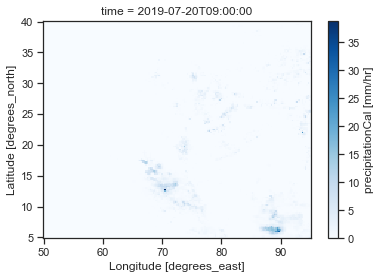

In [16]:
ds1.precipitationCal.sel(time = "2019-07-20 09:00:00").plot()

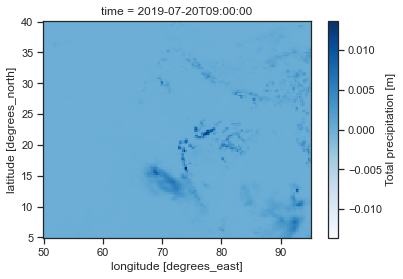

In [20]:
ds2.tp.sel(time = "2019-07-20 09:00:00").plot(cmap = "Blues")

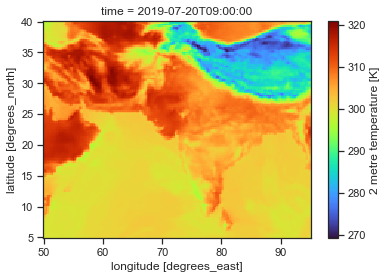

In [21]:
ds2.t2m.sel(time = "2019-07-20 09:00:00").plot(cmap='turbo')

In [22]:
# ds3.precipitation.sel(time = "2019-07-20 09:00:00").plot()

## Data Preparation

**We will use ds1 and ds2. We need to -**

1) coarsen the dimensions of precipitation data ***(DONE)***

2) bin the precipitation and temperature data

3) find a way to visualise the c-c scaling after fitting the exponential function.

In [23]:
ds1.dims

Frozen({'time': 5855, 'lon': 181, 'lat': 141})

In [24]:
ds2.dims

Frozen({'lon': 181, 'lat': 141, 'time': 2928})

In [25]:
ds1.precipitationCal.shape

(5855, 141, 181)

In [26]:
ds2.t2m.shape

(2928, 141, 181)

In [27]:
precip30m = ds1.precipitationCal
precip1h = ds1.precipitationCal.resample(time = '1H').mean()
# precip3h = ds1.precipitationCal.resample(time = '3H').mean()
# precip6h = ds1.precipitationCal.resample(time = '6H').mean()
# precip12h = ds1.precipitationCal.resample(time = '12H').mean()
# precip1d = ds1.precipitationCal.resample(time = '1D').mean()

t2m = ds2.t2m
d2m = ds2.d2m
u10 = ds2.u10
v10 = ds2.v10
tp = ds2.tp
v = np.sqrt(u10**2 + v10**2)

In [28]:
precip30m.shape

(5855, 141, 181)

In [29]:
precip1h.shape

(2928, 141, 181)

In [30]:
t2m.shape

(2928, 141, 181)

### Data binning

In [31]:
ds_comb = xr.merge([precip1h, t2m]).chunk(dict(time=-1))

In [32]:
ds_comb

<xarray.Dataset>
Dimensions:           (lon: 181, lat: 141, time: 2928)
Coordinates:
  * lon               (lon) float64 50.0 50.25 50.5 50.75 ... 94.5 94.75 95.0
  * lat               (lat) float64 5.0 5.25 5.5 5.75 ... 39.25 39.5 39.75 40.0
  * time              (time) datetime64[ns] 2019-06-01 ... 2019-09-30T23:00:00
Data variables:
    precipitationCal  (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>
    t2m               (time, lat, lon) float32 dask.array<chunksize=(2928, 141, 181), meta=np.ndarray>

In [71]:
def get_binned(ds, lat, lon, percentile_val, bins):
    return ds.sel(lat = lat, lon = lon).groupby_bins('t2m', bins).quantile(percentile_val, interpolation = 'midpoint')

(290.0, 320.0)

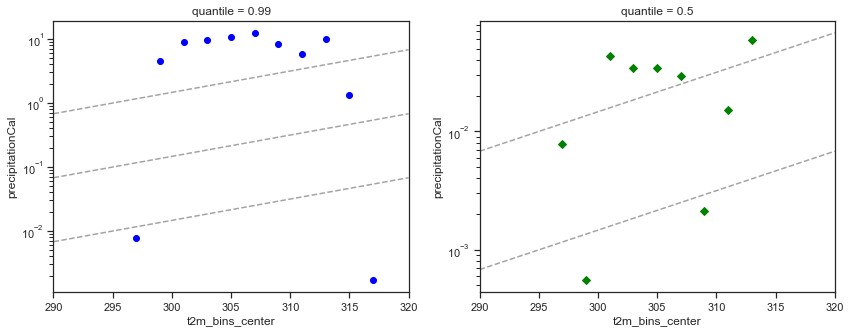

In [66]:
fig = plt.figure(figsize=(14,5))
plt.subplot(121)
get_binned(ds_comb, 19.5, 72.5, 0.99, np.arange(270,330,2)).precipitationCal.plot(marker = 'o', yscale='log', linewidth = 0., color = 'blue')

plt.semilogy([290,320], [0.0068, 0.068], 'k--', alpha = 0.4)
plt.semilogy([290,320], [0.068, 0.068 * 10], 'k--', alpha = 0.4)
plt.semilogy([290,320], [0.068*10, 0.068 * 100], 'k--', alpha = 0.4)
plt.xlim(290,320)

plt.subplot(122)
get_binned(ds_comb, 19.5, 72.5, 0.5, np.arange(270,330,2)).precipitationCal.plot(marker = 'D', yscale='log', linewidth = 0., color = 'green')

plt.semilogy([290,320], [0.00068, 0.0068], 'k--', alpha = 0.4)
plt.semilogy([290,320], [0.0068, 0.068], 'k--', alpha = 0.4)
plt.xlim(290,320)